# Capter 3: Methods (part 1)

This chapter outlines the methodology and workflow employed to achieve the project objectives.


In [ ]:
import torch
from utils.inits import init_pytorch
from configs._scanners import get_miniPET_geometry
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


              -  -  -  -  -  -  -  -   -  -  -  -
              P  A  R  A  L  L  E  L | P  R  O  J
              -  -  -  -  -  -  -  -   -  -  -  -


             Please consider citing our publication
          ---------------------------------------------
          Georg Schramm and Kris Thielemans:
          "PARALLELPROJ—an open-source framework for
           fast calculation of projections in
           tomography"
          Front. Nucl. Med., 08 January 2024
          Sec. PET and SPECT, Vol 3
          https://doi.org/10.3389/fnume.2023.1324562

 
        parallelproj C    lib         ..: C:\Users\simone\miniconda3\envs\smn\Library\bin\parallelproj_c.dll
        parallelproj CUDA lib         ..: None
        parallelproj CUDA kernel file ..: None
        parallelproj CUDA present     ..: False
        parallelproj cupy enabled     ..: False
        


In [6]:
# Initialise the device
device: torch.device = init_pytorch()

# Set volume dimensions
IMG_WIDTH: int = 147
IMG_HEIGHT: int = 147
IMG_DEPTH: int = 35

Using CPU...


In [7]:
# Create the miniPET geometry
miniPET_geometry = get_miniPET_geometry(
    device=device, img_width=IMG_WIDTH, img_height=IMG_HEIGHT, num_rings=IMG_DEPTH
)

In [ ]:
BATCH_SIZE: int = 6
TRAIN_SAMPLES: int = 500
SLICE_TO_PLOT: int = 17

# Maximum number of labels in each image
N_LABELS: int = 6

## Training data

The images in the training dataset were randomly generated on the fly using two approaches: one based on ellipsoidal labels and the other on randomly shaped labels. Each approach had a 50% chance of being selected to generate an image of the training set.


### Random Ellipsoids


In [ ]:
from typing import Literal

import numpy as np
import torch
from parallelproj import RegularPolygonPETProjector
from torch.utils.data import Dataset
from torchvision.transforms import functional as F

from utils.ellipsoids import generate_random_3d_ellipsoids
from utils.synthmorph import draw_perlin, labels_to_image, minmax_norm


class RandomShapes(Dataset):
    """A PyTorch Dataset class that generates 3D random shapes."""

    def __init__(
        self,
        device: torch.device,
        projector: RegularPolygonPETProjector,
        n_imgs: int,
        n_labels: int = 5,
        noise_interval: tuple = (0.0, 1.0),
        kernel_size: int = 5,
        sigma: float = 2.0,
        modality: Literal["ellipsoids", "shapes", "mixed"] = "mixed",
    ):
        """Initialises the RandomShapes dataset.

        Args:
            device (torch.device): The device to use.
            proj (RegularPolygonPETProjector): The projector to use for the dataset.
            n_imgs (int): The number of objects to generate.
            n_labels (int, optional): The number of possible different labels in the label map. Defaults to 5.
            noise_interval (tuple, optional): The interval for the Poisson noise. Defaults to (0.0, 1.0) (no noise).
            kernel_size (int, optional): The size of the Gaussian blur kernel. Defaults to 5.
            sigma (float, optional): The standard deviation of the Gaussian blur kernel. Defaults to 2.0.
            modality (Literal["ellipsoids", "shapes", "mixed"], optional): The modality of the dataset. Defaults to "mixed".
                If "ellipsoids", only ellipsoids are generated. If "shapes", only shapes are generated. If "mixed", both are
                generated with equal probability.
        """
        self.device = device
        self.projector = projector

        # Image parameters
        self.n_imgs = n_imgs
        self.img_shape = projector.in_shape

        # Shapes parameters
        self.n_labels = n_labels

        # Noise parameters
        self.noise_interval = noise_interval

        # Guassian blur
        self.kernel_size = kernel_size
        self.sigma = sigma

        # Modality
        self.modality = modality

        if self.modality not in ["ellipsoids", "shapes", "mixed"]:
            raise ValueError(
                "Invalid modality. Choose between 'ellipsoids', 'shapes' and 'mixed'."
            )

    def __getitem__(self, _) -> tuple:
        """Generates a single 3D random ellipsoid phantom.

        Args:
            _ (int): The index of the image to generate.

        Returns:
            Tuple: The generated sinogram, the image tensors, the label map tensor and the labels mapping dict.
        """
        sino, img, labels, mapping = self.generate_shapes()

        return sino, img, labels, mapping

    def __len__(self) -> int:
        """Returns the number of images in the dataset.

        Returns:
            int: Number of images in the dataset.
        """
        return self.n_imgs

    def _create_image_from_label_maps(self, label_map: torch.Tensor) -> tuple:
        """Creates an image from the label map.

        Args:
            label_map (torch.Tensor): The label map to convert.

        Returns:
            dict: The generated image and the label map.
        """
        gen = labels_to_image(self.device, label_map)
        gen_img = gen["image"]
        gen_label_map = gen["labels"]
        gen_mapping = gen["mapping"]

        # Combine the two label maps
        gen_label_map = self._pad_label_maps(gen_label_map, self.n_labels * 2)
        gen_mapping = torch.nn.functional.pad(
            gen_mapping,
            (0, self.n_labels * 2 - gen_mapping.shape[0]),
            mode="constant",
            value=-42,
        )

        return gen_img, gen_label_map, gen_mapping

    def _generate_label_maps(self) -> torch.Tensor:
        """Generates the labels for the image.

        Returns:
            list: A list of label maps.
        """
        label_map = torch.zeros(*self.img_shape).to(self.device)

        label_map_list = []

        while len(torch.unique(label_map)) < 2:  # Avoid empty label maps
            # Select the modality
            if self.modality == "ellipsoids":
                img_type = 0
            elif self.modality == "shapes":
                img_type = 1
            else:
                img_type = torch.rand(1)  # Randomly select the modality

            if img_type > 0.5:
                for _ in range(2):
                    # Generate the labels using Perlin noise
                    im = draw_perlin(
                        device=self.device,
                        out_shape=(*self.img_shape, self.n_labels),
                        scales=[32, 64, 128],
                        max_std=1,
                    )
                    im = self._create_geodes(im)
                    label_map += torch.argmax(im, dim=0)
                    label_map_list.append(torch.argmax(im, dim=0))
            else:
                for _ in range(2):
                    # Generate the labels using Random Ellipsoids
                    im = generate_random_3d_ellipsoids(
                        device=self.device,
                        diag_len=200,
                        out_shape=self.img_shape,
                        n_ellipsoids=self.n_labels - 1,
                    )
                    label_map_list.append(im)
                    label_map += im
                # Substract ellipsoids to make holes
                im = generate_random_3d_ellipsoids(
                    device=self.device,
                    diag_len=200,
                    out_shape=self.img_shape,
                    n_ellipsoids=np.random.randint(self.n_labels // 2, self.n_labels),
                )
                label_map_list.append(im)
                label_map -= im

        if img_type == 1:
            # Plot the process
            fig = plt.figure(figsize=(20, 5))
            ax1 = fig.add_subplot(1, 3, 1)
            ax1.imshow(
                label_map_list[0][:, 16, :].cpu().numpy(),
                cmap="Set3",
                interpolation="nearest",
            )
            ax1.set_title("Label map 1")
            plt.xlabel(r"$x$")
            plt.ylabel(r"$y$")
            ax2 = fig.add_subplot(1, 3, 2)
            ax2.imshow(
                label_map_list[1][:, 16, :].cpu().numpy(),
                cmap="Set3",
                interpolation="nearest",
            )
            ax2.set_title("Label map 2")
            plt.xlabel(r"$x$")
            plt.ylabel(r"$y$")
            ax3 = fig.add_subplot(1, 3, 3)
            ax3.imshow(
                label_map[:, 16, :].cpu().numpy(),
                cmap="Set3",
                interpolation="nearest",
            )
            ax3.set_title("Combined Label map")
            plt.xlabel(r"$x$")
            plt.ylabel(r"$y$")
            plt.show()
        else:
            # Plot the process
            fig = plt.figure(figsize=(20, 5))
            ax1 = fig.add_subplot(1, 4, 1)
            ax1.imshow(
                label_map_list[0][:, 16, :].cpu().numpy(),
                cmap="Set3",
                interpolation="nearest",
            )
            ax1.set_title("Label map 1")
            plt.xlabel(r"$x$")
            plt.ylabel(r"$y$")

            ax2 = fig.add_subplot(1, 4, 2)
            ax2.imshow(
                label_map_list[1][:, 16, :].cpu().numpy(),
                cmap="Set3",
                interpolation="nearest",
            )
            ax2.set_title("Label map 2")
            plt.xlabel(r"$x$")
            plt.ylabel(r"$y$")
            ax3 = fig.add_subplot(1, 4, 3)
            ax3.imshow(
                label_map_list[2][:, 16, :].cpu().numpy(),
                cmap="Set3",
                interpolation="nearest",
            )
            ax3.set_title("Label map 3")
            plt.xlabel(r"$x$")
            plt.ylabel(r"$y$")
            ax4 = fig.add_subplot(1, 4, 4)
            ax4.imshow(
                torch.clamp_(label_map, 0)[:, 16, :].cpu().numpy(),
                cmap="Set3",
                interpolation="nearest",
            )
            ax4.set_title("Combined Label map")
            plt.xlabel(r"$x$")
            plt.ylabel(r"$y$")
            plt.show()

        return torch.clamp_(label_map, 0)

    def _create_geodes(self, perlin_noise: torch.Tensor) -> torch.Tensor:
        """Creates a geodesic shape from the Perlin noise.

        Args:
            perlin_noise (torch.Tensor): The Perlin noise tensor.

        Returns:
            torch.Tensor: The geodesic shape tensor.
        """
        # Get dimensions
        n_labels, sizeX, sizeY, sizeZ = perlin_noise.shape

        # Center coordinates
        centerX = sizeX // 2
        centerY = sizeY // 2
        centerZ = sizeZ // 2

        # Create a grid of coordinates
        x_coords = torch.arange(sizeX).view(-1, 1, 1).repeat(1, sizeY, sizeZ)
        y_coords = torch.arange(sizeY).view(1, -1, 1).repeat(sizeX, 1, sizeZ)
        z_coords = torch.arange(sizeZ).view(1, 1, -1).repeat(sizeX, sizeY, 1)

        # Calculate squared distances
        distanceX = (centerX - x_coords) ** 2
        distanceY = (centerY - y_coords) ** 2
        distanceZ = (centerZ - z_coords) ** 2

        # Calculate Euclidean distance to the center
        distanceToCenter = torch.sqrt(
            distanceX + distanceY + distanceZ
        ) * np.random.uniform(1.5, 2.5)

        # Normalize the distance
        distanceToCenter = distanceToCenter / max(sizeX, sizeY, sizeZ)

        distanceToCenter = (
            distanceToCenter.unsqueeze(0).expand(n_labels, -1, -1, -1).to(self.device)
        )

        geodesic_perlin = torch.clamp(
            minmax_norm(perlin_noise) - distanceToCenter, 0, 1
        )

        return geodesic_perlin

    def _pad_label_maps(
        self, label_map: torch.Tensor, n_labels: int = 10
    ) -> torch.Tensor:
        """Pad a label map with zeros to match a target size on the first dimension.

        Args:
            label_map (torch.Tensor): The input tensor to pad.
            n_labels (int): The target size for the first dimension (default is 10).

        Returns:
            torch.Tensor: A tensor of shape padded with zeros to match the target size on the first dimension.
        """
        # Get the current shape of the input tensor
        labels_shape, *img_shape = label_map.shape

        if labels_shape < n_labels:
            # Fill with zeros to match the target size
            padding = torch.zeros((n_labels - labels_shape, *img_shape)).to(self.device)

            # Concatenate the input tensor with the padding along the first dimension
            padded_label_map = torch.cat((label_map, padding), dim=0)
        else:
            padded_label_map = label_map

        return padded_label_map

    def generate_shapes(self) -> tuple:
        """Generates a single 3D random shape.

        Returns:
            Tuple: The generated sinogram, image, label map tensors and the labels mapping dict.
        """

        # Generate the labels
        label_map_list = self._generate_label_maps()

        # Create the image from the labels
        image, label_map, mapping = self._create_image_from_label_maps(label_map_list)

        # Apply Gaussian blur to the image
        image_blur = F.gaussian_blur(
            image,
            kernel_size=[self.kernel_size, self.kernel_size],
            sigma=[self.sigma, self.sigma],
        )

        # Project the ellipsoids to generate the sinogram
        sinogram = self.projector(image_blur)

        # Add Poisson noise to the sinogram
        if self.noise_interval[1] > 0:
            noise_level = np.random.uniform(*self.noise_interval)
            # Clamp the sinogram to be non-negative
            sinogram = torch.clamp_min(sinogram, 0)
            # Add Poisson noise
            sinogram = torch.poisson(sinogram / noise_level) * noise_level

        return (sinogram, image, label_map, mapping)

In [ ]:
synthetic_dataset = RandomShapes(
    device,
    projector=miniPET_geometry.proj,
    n_imgs=TRAIN_SAMPLES,
    n_labels=N_LABELS,
    noise_interval=(0.1, 1.2),
    kernel_size=5,
    sigma=2.0,
    modality="ellipsoids",
)

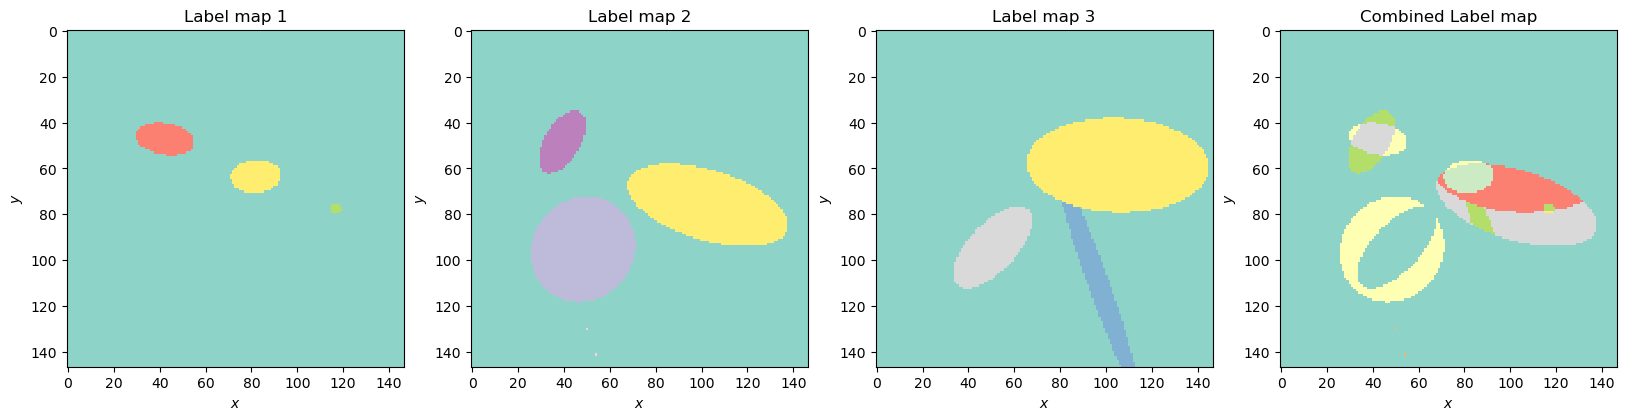

In [34]:
data_loader = DataLoader(synthetic_dataset, batch_size=1, shuffle=True)

# Get the first batch of the data loader
data_loader_iter = iter(data_loader)
sinogram_ellips, image_ellips, label_ellips, maps = next(data_loader_iter)

### Random Shapes


In [ ]:
synthetic_dataset = RandomShapes(
    device,
    projector=miniPET_geometry.proj,
    n_imgs=TRAIN_SAMPLES,
    n_labels=N_LABELS,
    noise_interval=(0.1, 1.2),
    kernel_size=5,
    sigma=2.0,
    modality="shapes",
)

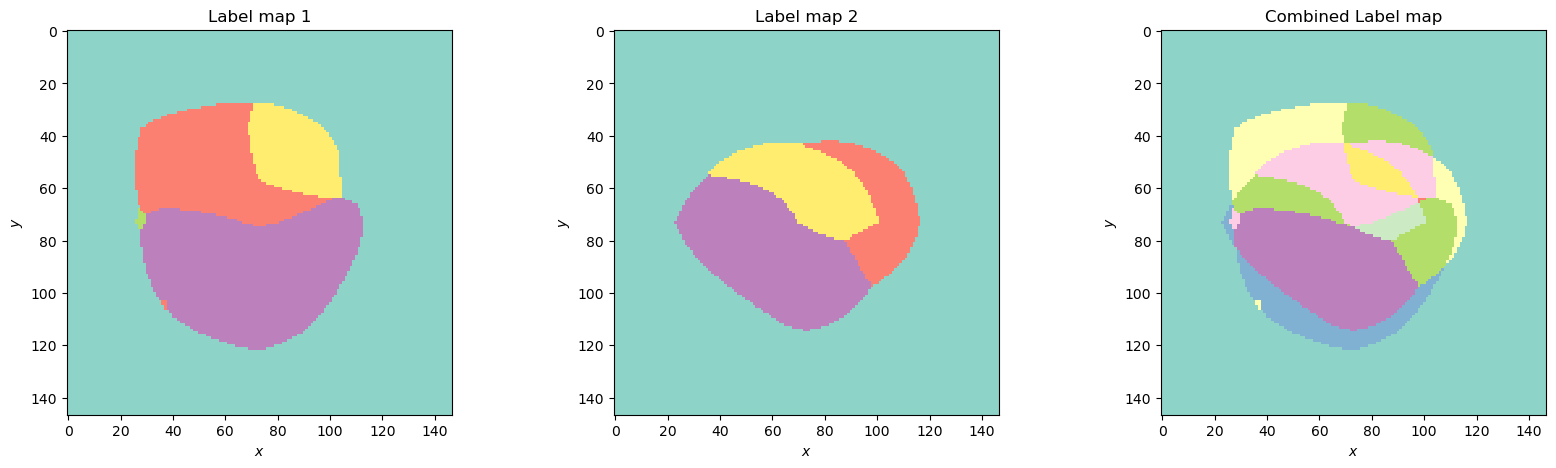

In [9]:
data_loader = DataLoader(synthetic_dataset, batch_size=1, shuffle=True)

# Get the first batch of the data loader
data_loader_iter = iter(data_loader)
sinogram_shapes, image_shapes, label_shapes, maps = next(data_loader_iter)

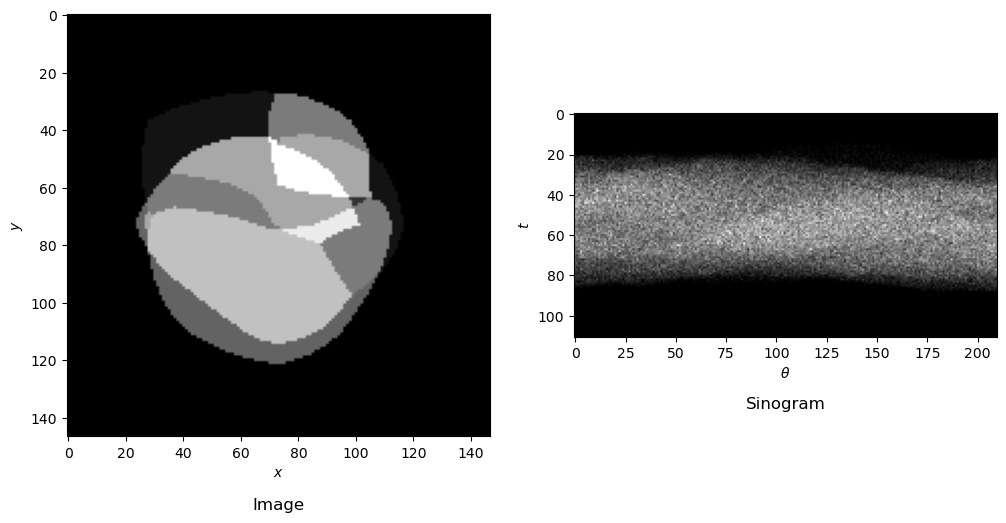

In [10]:
# Plot the phantom and sinogram
plt.figure(figsize=(12, 6))

# Plot the phantom
plt.subplot(121)
plt.imshow(image_shapes.squeeze()[:, SLICE_TO_PLOT, :].cpu().numpy(), cmap="grey")
plt.title("Image", y=-0.01, pad=-50)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.axis("on")

# Plot the sinogram
plt.subplot(122)
plt.imshow(sinogram_shapes.squeeze()[:, :, SLICE_TO_PLOT].cpu().numpy(), cmap="grey")
plt.title("Sinogram", y=-0.01, pad=-50)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$t$")
plt.axis("on")

plt.show()

### Examples

The synthetic generator produces phantoms in a wide variety of shapes and sizes due to the randomness of the generation process. In the following Figure, the central slices of 24 different synthetic phantoms are presented as examples.


In [ ]:
from generators.mixed import MixedDataset


synthetic_dataset = MixedDataset(
    device,
    projector=miniPET_geometry.proj,
    n_imgs=TRAIN_SAMPLES,
    n_labels=N_LABELS,
    noise_interval=(0.1, 1.2),
    kernel_size=5,
    sigma=2.0,
)

data_loader = DataLoader(synthetic_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Get the first batch of the data loader
data_loader_iter = iter(data_loader)

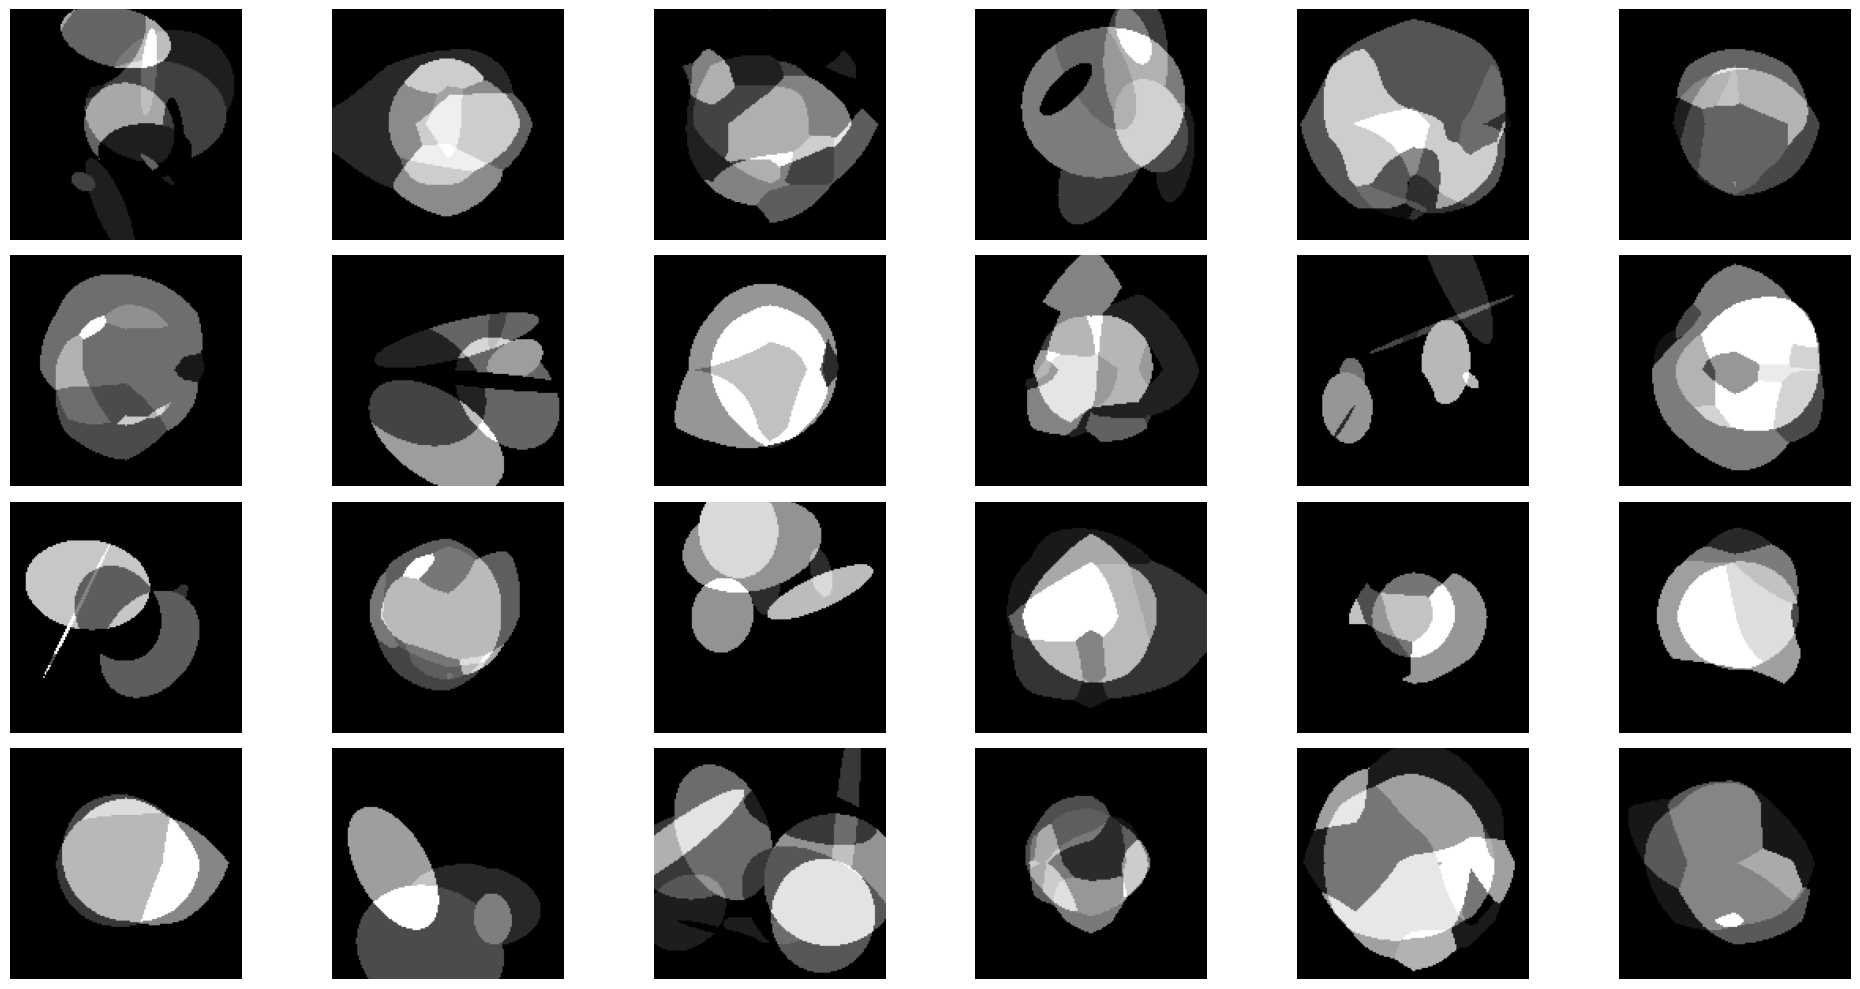

In [12]:
rows = 4
# Plot all the phantom in the batch
plt.figure(figsize=(20, 10))
for j in range(rows):
    _, image_shapes, _, _ = next(data_loader_iter)
    for i, img in enumerate(image_shapes):
        plt.subplot(rows, BATCH_SIZE, i + 1 + j * BATCH_SIZE)
        plt.imshow(img[:, SLICE_TO_PLOT, :].cpu().numpy(), cmap="gray")
        plt.axis("off")
plt.tight_layout()
plt.show()

## Synthetic Test data

A 3D Shepp–Logan phantom is used to test the reconstructions on synthetic, yet realistic data. This phantom is an abstract representation of a human brain and it’s the most common test object for testing reconstruction algorithms.


In [7]:
from utils.data import create_SLPhantom

In [ ]:
# Create the Shepp-Logan phantom and its sinogram
sinogram_slp, image_slp = create_SLPhantom(
    device, IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH, miniPET_geometry.proj, noise_level=0.5
)

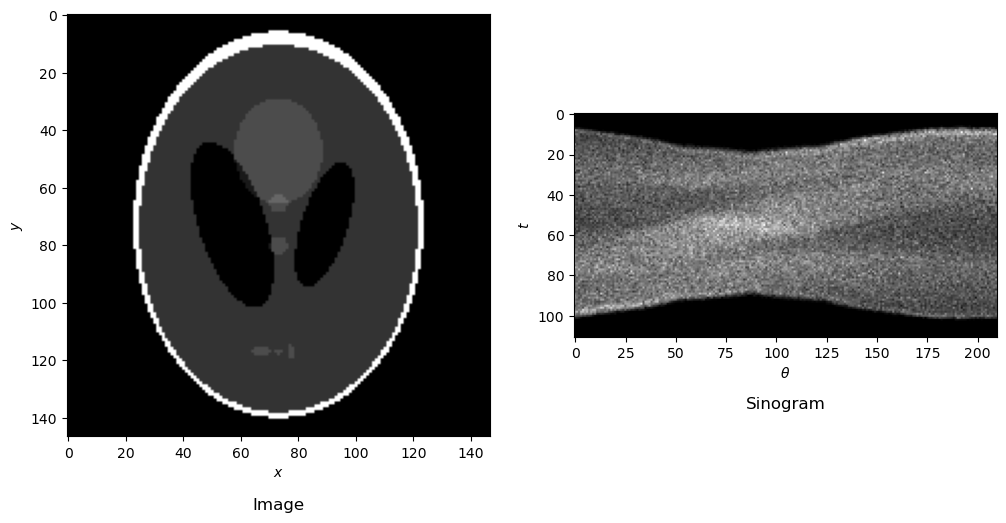

In [ ]:
# Plot the phantom and the sinogram
plt.figure(figsize=(12, 6))

# Plot the phantom
plt.subplot(121)
plt.imshow(image_slp.squeeze()[:, SLICE_TO_PLOT, :].cpu().numpy(), cmap="grey")
plt.title("Image", y=-0.01, pad=-50)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.axis("on")

# Plot the sinogram
plt.subplot(122)
plt.imshow(sinogram_slp.squeeze()[:, :, SLICE_TO_PLOT].cpu().numpy(), cmap="grey")
plt.title("Sinogram", y=-0.01, pad=-50)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$t$")
plt.axis("on")

plt.show()

## Pre-clinical Test data

Experimental data are used to validate the reconstructions in a realistic scenario. These data were acquired by A. Guazzo and M. Colarieti-Tosti using the MiniPET-3, for the ”Learned Primal Dual Reconstruction for PET” article.

The test object is a mouse-like phantom. It was loaded with Fludeoxyglucose (FDG) and the activity concentrations of the various zones are described in Table 3.1. Using this experimental setup 60 one-minute-equivalent long acquisitions were collected.


In [16]:
from utils.data import load_miniPET_sino, load_miniPET_img

In [ ]:
# Select the file path of the sinogram
FILE_SINO_PATH: str = "data/sino60min.sino.mnc"

sinogram_mouse = load_miniPET_sino(device, FILE_SINO_PATH)

In [ ]:
# Select the file path of the sinogram
FILE_IMG_PATH: str = "data/GT.mnc"

image_mouse = load_miniPET_img(device, FILE_IMG_PATH)

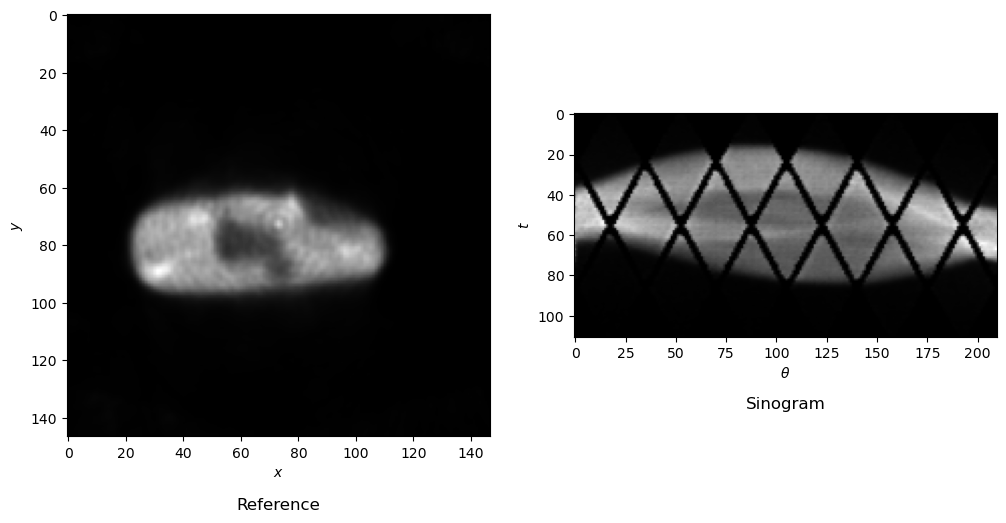

In [ ]:
# Plot the phantom and the sinogram
plt.figure(figsize=(12, 6))

# Plot the phantom
plt.subplot(121)
plt.imshow(image_mouse.squeeze()[:, SLICE_TO_PLOT, :].cpu().numpy(), cmap="grey")
plt.title("Reference", y=-0.01, pad=-50)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.axis("on")

# Plot the sinogram
plt.subplot(122)
plt.imshow(sinogram_mouse.squeeze()[:, :, SLICE_TO_PLOT].cpu().numpy(), cmap="grey")
plt.title("Sinogram", y=-0.01, pad=-50)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$t$")
plt.axis("on")

plt.show()

## Sinograms Embeddings

For the creation of embeddings in the sinogram domain, the input must be treated as a sequence of projections for the assumption of locality of information contained in a token to hold.


### Dual-Domain Transformer LPD

To embed the singrams, points belonging to the bundle of projections (curve) are identified by forward projecting small $7\times7$ patches from the image domain to the sinogram domain


In [11]:
miniPET_geometry_patch = get_miniPET_geometry(
    device=device,
    img_width=IMG_WIDTH,
    img_height=IMG_HEIGHT,
    num_rings=1,
    distance_between_rings=0,
)

In [15]:
import math

import torch
import torch.nn.functional as F
from parallelproj import RegularPolygonPETProjector


def sinogram_patching(
    device: torch.device, projector: RegularPolygonPETProjector, patch_size: int = 7
):
    # Get the shape of the input image (height, width, depth)
    image_shape = projector.in_shape

    # Calculate the number of patches along one dimension and total number of patches
    patch_dim = int(math.ceil(image_shape[0] / patch_size))  # Patches per dimension
    patch_num = patch_dim**2  # Total number of patches

    # Create a tensor to hold the patches
    images = torch.zeros(patch_num, image_shape[0], 1, image_shape[2]).to(device)

    # Loop over each patch
    for k in range(patch_num):
        # Determine the i, j coordinates of the current patch in the patch grid
        i = k // patch_dim  # Row index
        j = k % patch_dim  # Column index

        # Fill the current patch with ones
        images[
            k,
            i * patch_size : (i + 1) * patch_size,
            0,
            j * patch_size : (j + 1) * patch_size,
        ] = 1

        # Project the current patch and store the sinogram
        sino = projector(images[k])

        plt.figure(figsize=(12, 6))

        plt.subplot(121)
        plt.imshow(images[k].squeeze(1).cpu().numpy(), cmap="grey")
        plt.title("Image", y=-0.01, pad=-50)
        plt.xlabel(r"$x$")
        plt.ylabel(r"$y$")
        plt.axis("on")

        plt.subplot(122)
        plt.imshow(sino.squeeze(1).cpu().numpy(), cmap="grey")
        plt.title("Sinogram", y=-0.01, pad=-50)
        plt.xlabel(r"$\theta$")
        plt.ylabel(r"$t$")
        plt.axis("on")

        plt.show()
        break

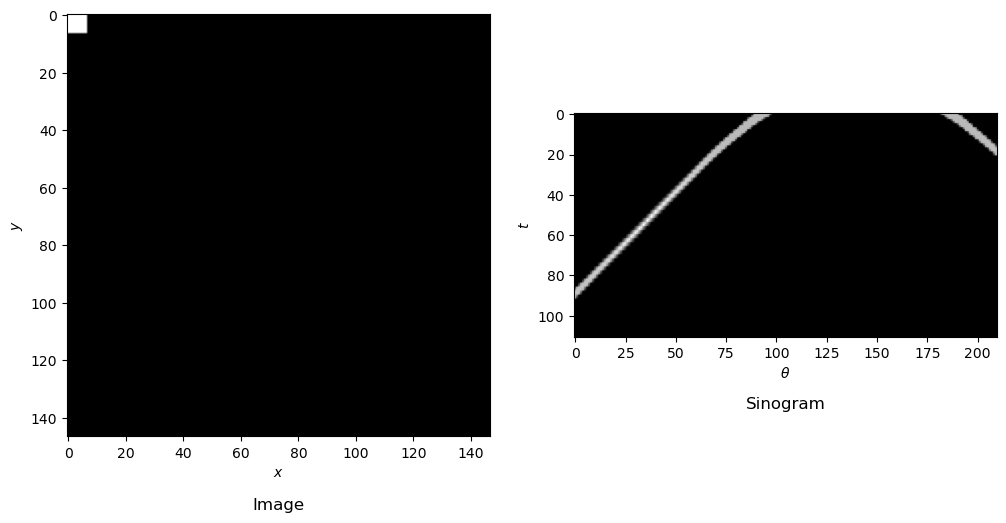

In [ ]:
sinogram_patching(device=device, projector=miniPET_geometry_patch.proj, patch_size=7)